Modify the KNN scratch code in our lecture such that:
- If the majority class of the first place is equal to the second place, then ask the algorithm to pick the next nearest neighbors as the decider
- Modify the code so it outputs the probability of the decision, where the probability is simply the class probability based on all the nearest neighbors
- Write a function which allows the program to receive a range of k, and output the cross validation score.  Last, it shall inform us which k is the best to use from a predefined range
- Put everything into a class <code>KNN(k=3)</code>.  It should have at least one method, <code>predict(X_train, X_test, y_train)</code>

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import average_precision_score, classification_report
from sklearn.preprocessing import label_binarize

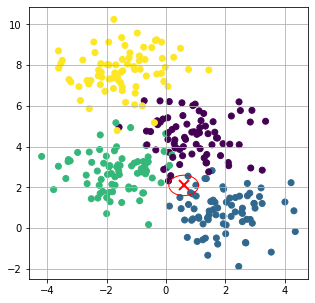

In [2]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)

xfit = np.linspace(-1, 3.5)

figure = plt.figure(figsize=(5, 5))
ax = plt.axes()  #get the instance of axes from plt

ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

#where should this value be classified as?
ax.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

#let's say roughly 5 neighbors
circle = plt.Circle((0.6, 2.1), 0.5, color='red', fill=False)
ax.add_artist(circle)

In [3]:
#standardize
scaler = StandardScaler()
X = scaler.fit_transform(X)

#do train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [4]:
class KNN:
    def __init__(self, k=3):
        self.k = k

    def find_distance(self, X_train, X_test):
        #create newaxis simply so that broadcast to all values
        dist = X_test[:, np.newaxis, :] - X_train[np.newaxis, :, :]
        sq_dist = dist ** 2

        #sum across feature dimension, thus axis = 2
        summed_dist = sq_dist.sum(axis=2)
        sq_dist = np.sqrt(summed_dist)
        return sq_dist

    def find_neighbors(self, X_train, X_test):
        dist = self.find_distance(X_train, X_test)
        #return the first k neighbors
        neighbors_ix = np.argsort(dist)[:, 0:self.k]
        return neighbors_ix

    def get_most_common(self, y, k):
        y_nearest = y[0:k]
        bincount = np.bincount(y_nearest)
        largest = bincount.argmax()
        second_largest = bincount.argsort()[-2:][0]
        prob = bincount[largest] / bincount.sum()
        if bincount[largest] == bincount[second_largest]:
            y_nearest = y[0: k+1]
            return np.bincount(y_nearest).argmax(), prob
        return largest, prob
    
    def cv(self, X_train, X_test, y_train, ka):
        yhat_cv = np.zeros((len(ka)))
        yhat_cv_prob = np.zeros((len(ka)))
        for k_idx, k in enumerate(ka):
            self.k = k
            yhat, yhat_prob = self.predict(X_train, X_test, y_train)
            acc = np.sum(yhat == y_test)/len(y_test)
            yhat_cv[k_idx] = acc
            yhat_cv_prob[k_idx] = yhat_prob.mean()
        return yhat_cv, yhat_cv_prob

    def predict(self, X_train, X_test, y_train):
        neighbors_ix = self.find_neighbors(X_train, X_test)
        pred = np.zeros(X_test.shape[0])
        prob = np.zeros(X_test.shape[0])
        for ix, y in enumerate(y_train[neighbors_ix]):
            yhat, yhat_prob = self.get_most_common(y, self.k)
            pred[ix] = yhat
            prob[ix] = yhat_prob
        return pred, prob

In [7]:
model = KNN(k=2) # k=2
yhat, prob = model.predict(X_train, X_test, y_train)

n_classes = len(np.unique(y_test))

print("Accuracy: ", np.sum(yhat == y_test)/len(y_test))

print("=========Average precision score=======")
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])
yhat_binarized = label_binarize(yhat, classes=[0, 1, 2, 3])

for i in range(n_classes):
    class_score = average_precision_score(y_test_binarized[:, i], yhat_binarized[:, i])
    print(f"Class {i} score: ", class_score)
    
print("=========Classification report=======")
print("Report: ", classification_report(y_test, yhat))
print("Prob.: ",prob.mean())

Accuracy:  0.9444444444444444
=========Average precision score=======
Class 0 score:  0.8275862068965517
Class 1 score:  0.9045751633986928
Class 2 score:  0.9452991452991454
Class 3 score:  0.9676328502415459
=========Classification report=======
Report:                precision    recall  f1-score   support

           0       0.83      1.00      0.91        24
           1       1.00      0.88      0.94        17
           2       1.00      0.92      0.96        26
           3       1.00      0.96      0.98        23

    accuracy                           0.94        90
   macro avg       0.96      0.94      0.95        90
weighted avg       0.95      0.94      0.95        90

Prob.:  0.9444444444444444


In [8]:
model = KNN()
ka = np.arange(2, 11)
yhat_cv, yhat_cv_prob = model.cv(X_train, X_test, y_train, ka)

for i, k in enumerate(ka):
    print(f"Score with k={k}: ", yhat_cv[i], " prob. score: ", yhat_cv_prob[i])

Score with k=2:  0.9444444444444444  prob. score:  0.9444444444444444
Score with k=3:  0.9444444444444444  prob. score:  0.9555555555555556
Score with k=4:  0.9444444444444444  prob. score:  0.9416666666666667
Score with k=5:  0.9555555555555556  prob. score:  0.94
Score with k=6:  0.9444444444444444  prob. score:  0.9407407407407408
Score with k=7:  0.9555555555555556  prob. score:  0.9412698412698414
Score with k=8:  0.9555555555555556  prob. score:  0.9375
Score with k=9:  0.9555555555555556  prob. score:  0.9308641975308641
Score with k=10:  0.9666666666666667  prob. score:  0.9266666666666667
